This notebook includes the data augmentation methods for manuscript se-2023-01258a (Zhang et al.) that is currently under review. The functions and parameters are adpoted and modified from literatures(1-3). 

1. Arthur Le Guennec, Simon Malinowski, Romain Tavenard. Data Augmentation for Time Series Classification using Convolutional Neural Networks. ECML/PKDD Workshop on Advanced Analytics and Learning on Temporal Data, Sep 2016, Riva Del Garda, Italy. ⟨halshs-01357973⟩

2. Iwana, B. K.; Uchida, S. An empirical survey of data augmentation for time series classification
with neural networks. Plos One 2021, 16, e0254841, DOI:10.1371/journal.pone.0254841

3. Um, T. T.; Pfister, F.M.J.; Pichler, D.; Endo, S.; Lang, M.; Hirche, S.; Fietzek, U.; Kulić, D. Data
augmentation of wearable sensor data for parkinson’s disease monitoring using convolutional
neural networks. In Proceedings of the 19th ACM International Conference on Multimodal
Interaction (ICMI '17). Association for Computing Machinery, New York, NY, USA, 216–220.
DOI:10.1145/3136755.3136817. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

In [3]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma) 
    return X*scalingFactor

In [4]:
from scipy.interpolate import CubicSpline 
def GenerateRandomCurves(X, sigma=0.2, knot=4): # 
    xx = (np.ones((1,1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, 1))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()

def DA_MagWarp(X, sigma = 0.2):
    return X * GenerateRandomCurves(X, sigma)

In [5]:
def window_slice(x, reduce_ratio=0.9):
    
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    starts = np.array([0])
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

In [6]:
sigma = 0.2
knot = 4

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) 
    
    tt_cum = np.cumsum(tt, axis=0)        
   
    t_scale = [(X.shape[0]-1)/tt_cum[-1]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]

    return tt_cum
    
def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new = np.interp(x_range, tt_new[:,0], X)
    
    return X_new

In [7]:
def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    
    warp_scales = np.random.choice(scales, 1)  
    warp_size = np.ceil(window_ratio*x.shape[0]).astype(int) 
    window_steps = np.arange(warp_size)  
    
    window_starts = np.random.randint(low=1, high=x.shape[0]-warp_size-1, size=1).astype(int) 
    window_ends = (window_starts + warp_size).astype(int)
    
    ret = np.zeros_like(x)
    for i in range(np.shape(x)[0]):
        for pat in range(np.shape(x)[1]):
            start_seg = x[:window_starts[0],pat]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales)), window_steps, x[window_starts[0]:window_ends[0], pat])
             
            end_seg = x[window_ends[0]:,pat]
            warped = np.concatenate((start_seg, window_seg, end_seg))
            
            ret[:, pat] = np.interp(np.arange(x.shape[0]), np.linspace(0, x.shape[0]-1., num=warped.size), warped).T
            
    return ret

In [8]:
import pandas as pd
data = pd.read_csv("interim_6-5-11 target sensingpeak_Hybridization_of_100_fM_miRNA.csv")
data

,file_name,t_raw (min),f (kHz),t(min),f (kHz)_f_final_minus_f_init,class
0,6-5-11 target sensingpeak_Hybridization_of_100...,107.949,31.9550,0.000,-0.000000,13
1,6-5-11 target sensingpeak_Hybridization_of_100...,108.304,31.9550,0.355,-0.000000,13
2,6-5-11 target sensingpeak_Hybridization_of_100...,108.660,31.9500,0.711,0.188679,13
3,6-5-11 target sensingpeak_Hybridization_of_100...,109.016,31.9485,1.067,0.245283,13
4,6-5-11 target sensingpeak_Hybridization_of_100...,109.371,31.9430,1.422,0.452830,13
...,...,...,...,...,...,...
114,6-5-11 target sensingpeak_Hybridization_of_100...,148.488,31.9290,40.539,0.981132,13
115,6-5-11 target sensingpeak_Hybridization_of_100...,148.843,31.9255,40.894,1.113208,13
116,6-5-11 target sensingpeak_Hybridization_of_100...,149.199,31.9265,41.250,1.075472,13
117,6-5-11 target sensingpeak_Hybridization_of_100...,149.554,31.9250,41.605,1.132075,13


In [9]:
def nor(data):
    i = data[0]
    e = data[len(data)-1]
    ndata = (data-i)/(e-i)
    return(ndata)

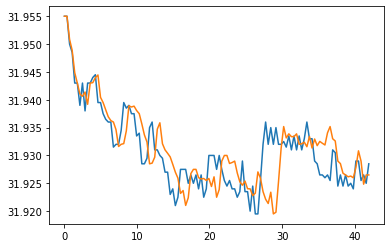

In [10]:
NfData = data.iloc[:, 2]
NfData = np.array(NfData)
NfData = np.reshape(NfData, (1, len(NfData), 1))
Wsdata = window_slice(NfData, reduce_ratio=0.9)
plt.plot(data.iloc[:, 3], data.iloc[:, 2])
plt.plot(data.iloc[:, 3], Wsdata[0])
plt.show()

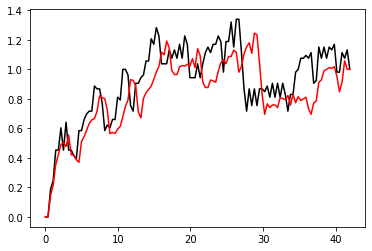

In [11]:
plt.plot(data.iloc[:, 3], data.iloc[:, 4], 'black')
plt.plot(data.iloc[:, 3], nor(Wsdata[0]), 'r')
plt.show()

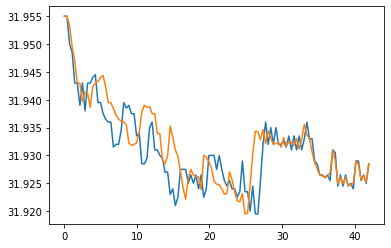

In [12]:
NfData = data.iloc[:, 2]
NfData = np.array(NfData)
TWdata = DA_TimeWarp(NfData, sigma=0.2)
plt.plot(data.iloc[:, 3], data.iloc[:, 2])
plt.plot(data.iloc[:, 3], TWdata)
plt.show()

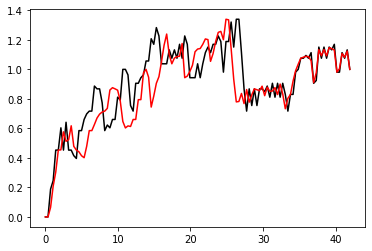

In [13]:
plt.plot(data.iloc[:, 3], data.iloc[:, 4], 'black')
plt.plot(data.iloc[:, 3], nor(TWdata), 'r')
plt.show()

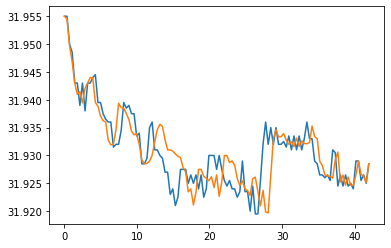

In [14]:
TFData = data.iloc[:, 3]
TFData = pd.DataFrame(TFData)
TFData.insert(1, 'f (kHz)', data.iloc[:, 2])
TFData = np.array(TFData)
Wwdata = window_warp(TFData, window_ratio=0.1, scales=[0.5, 2.])
plt.plot(data.iloc[:, 3], data.iloc[:, 2])
plt.plot(data.iloc[:, 3], Wwdata[:, 1])
plt.show()

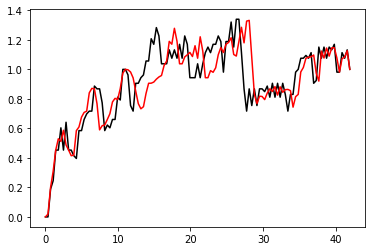

In [15]:
plt.plot(data.iloc[:, 3], data.iloc[:, 4], 'black')
plt.plot(data.iloc[:, 3], nor(Wwdata[:, 1]), 'r')
plt.show()